# 파일 명 지정

In [22]:
FILE_NAME = "제주도여행"

In [23]:
import re
import pandas as pd
import datetime as dt

In [24]:
# TXT 메세지 읽어오기
def read_kko_msg(filename):
    with open(filename, encoding='utf-8') as f:
        msg_list = f.readlines()
    return msg_list

# TXT -> 엑셀로 변환
def apply_kko_regex(msg_list):
    kko_pattern = re.compile("\[([\S\s]+)\] \[(오전|오후) ([0-9:\s]+)\] ([^\n]+)")
    kko_date_pattern = re.compile("--------------- ([0-9]+년 [0-9]+월 [0-9]+일) ")

    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    kko_parse_result = list()
    cur_date = ""

    for msg in msg_list:
        # 날짜 부분인 경우
        if len(kko_date_pattern.findall(msg)) > 0:
            cur_date = dt.datetime.strptime(kko_date_pattern.findall(msg)[0], "%Y년 %m월 %d일")
            cur_date = cur_date.strftime("%Y-%m-%d")
        else:
            kko_pattern_result = kko_pattern.findall(msg)
            if len(kko_pattern_result) > 0:
                tokens = list(kko_pattern_result[0])
                # 이모지 데이터 삭제
                tokens[-1] = re.sub(emoji_pattern, "", tokens[-1])
                tokens.insert(0, cur_date)
                kko_parse_result.append(tokens)

    kko_parse_result = pd.DataFrame(kko_parse_result, columns=["Date", "User", "timetype", "time", "Message"])
    kko_parse_result.to_csv("data/{}.csv.".format(FILE_NAME), index=False)

    return kko_parse_result

# 1. 데이터 불러오기
## TXT 메세지 읽어오기

In [25]:
msg_list = read_kko_msg("data/{}.txt".format(FILE_NAME))

## TXT -> 엑셀로 변환

In [26]:
apply_kko_regex(msg_list)
df = pd.read_csv("data/{}.csv".format(FILE_NAME))
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 5 columns):
Date        5840 non-null object
User        5840 non-null object
timetype    5840 non-null object
time        5840 non-null object
Message     5834 non-null object
dtypes: object(5)
memory usage: 228.2+ KB
None
         Date     User timetype  time                       Message
0  2019-10-28  엄수진 :-)       오후  3:35                     다들 안녕하세염!
1  2019-10-28   다은이♥♥♥       오후  3:36                           우와앙
2  2019-10-28   다은이♥♥♥       오후  3:36                          이모티콘
3  2019-10-28  엄수진 :-)       오후  3:37  초대됐으니 무적권 세부 가야되는건 아니니까 부담노노
4  2019-10-28  엄수진 :-)       오후  3:37          최대한 조율가능! 필잘알 상시대기 중


# 2. 데이터 전처리

## 메세지 분리

In [27]:
corpus = df['Message']
corpus

0                          다들 안녕하세염!
1                                우와앙
2                               이모티콘
3       초대됐으니 무적권 세부 가야되는건 아니니까 부담노노
4               최대한 조율가능! 필잘알 상시대기 중
                    ...             
5835                  빨간색 드레스로 부탁합니다
5836                            이모티콘
5837         저랑 스냑은 6시 퇴근해서 바로 가겠읍니다
5838                             네넹!
5839                     대장님도 빨리오십시오
Name: Message, Length: 5840, dtype: object

In [28]:
import re

def message_cleaning(docs):

    """
        1. Photo, Emoticon은 그 내용을 알 수 없으므로 제거.
        
        2. 자음/모음 표현 처리방법.
        
            1) "ㅇㅇ" ,"ㅋㅋㅋㅋㅋ" 같은 자음만 존재하는 표현이나, "ㅡㅡ", "ㅠㅠ" 같은 모음만 존재하는 표현들은
            의미는 있으나 중요한 의미를 가지고 있지 않다고 판단하여 제거.
            
            2) 이러한 표현들도 전부 emoticon 같은 감정 표현의 의성어로 쓰거나, 단축 표현이므로 제거하지 않음. 
            
        3. http:// 로 시작하는 hyperlink 제거.
        
        4. 특수문자 제거.
    
    """
    # Series의 object를 str로 변경.
    docs = [str(doc) for doc in docs]
    
    # 1
    pattern1 = re.compile("이모티콘|사진|샵검색")
    docs = [pattern1.sub("", doc) for doc in docs]
    
    # 2
    pattern2 = re.compile("[ㄱ-ㅎ]*[ㅏ-ㅢ]*")
    docs = [pattern2.sub("", doc) for doc in docs]
    
    # 3
    pattern3 = re.compile(r"\b(https?:\/\/)?([\w.]+){1,2}(\.[\w]{2,4}){1,2}(.*)")
    docs = [pattern3.sub("", doc) for doc in docs]
    
    # 4
    pattern4 = re.compile("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]")
    docs = [pattern4.sub("", doc) for doc in docs]

    return docs

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
    #return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]

In [29]:
SW = define_stopwords("data/stopwords-ko.txt")
# 카카오톡 텍스트를 정제합니다.
cleaned_corpus = message_cleaning(corpus)
print(len(cleaned_corpus))
print(cleaned_corpus[:10])

5840
['다들 안녕하세염', '우와앙', '', '초대됐으니 무적권 세부 가야되는건 아니니까 부담노노', '최대한 조율가능 필잘알 상시대기 중', '믿음직', '', '그런거보다 제가 요새 빨고 있는 주작돌이나 좀 보셈', '머리 반반이에여', '저는 좋아요']


In [30]:
# 정제되어 지워지는 텍스트들을 확인하고 지워줍니다.
cleaned_text = pd.Series(cleaned_corpus)
df["Message"] = cleaned_text
cleaned_data = df[df["Message"] != ""]
cleaned_data.reset_index(inplace=True, drop=True)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5072 entries, 0 to 5071
Data columns (total 5 columns):
Date        5072 non-null object
User        5072 non-null object
timetype    5072 non-null object
time        5072 non-null object
Message     5072 non-null object
dtypes: object(5)
memory usage: 198.2+ KB


# 3. 대화 분석

In [31]:
import nltk
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc

## 전체 대화 빈도 분석

In [32]:
def all_analysis():
    corpus = cleaned_data["Message"]
    total_tokens = [token for msg in corpus for token in str(msg).split()]
    text = nltk.Text(total_tokens, name='NMSC')
    path = "c:/Windows/Fonts/malgun.ttf"
    if platform.system() == 'Darwin':
        rc('font', family='AppleGothic')
    elif platform.system() == 'Windows':
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    else:
        print('Unknown system... sorry~~~~')

    plt.figure(figsize=(16, 10))
    text.plot(60)

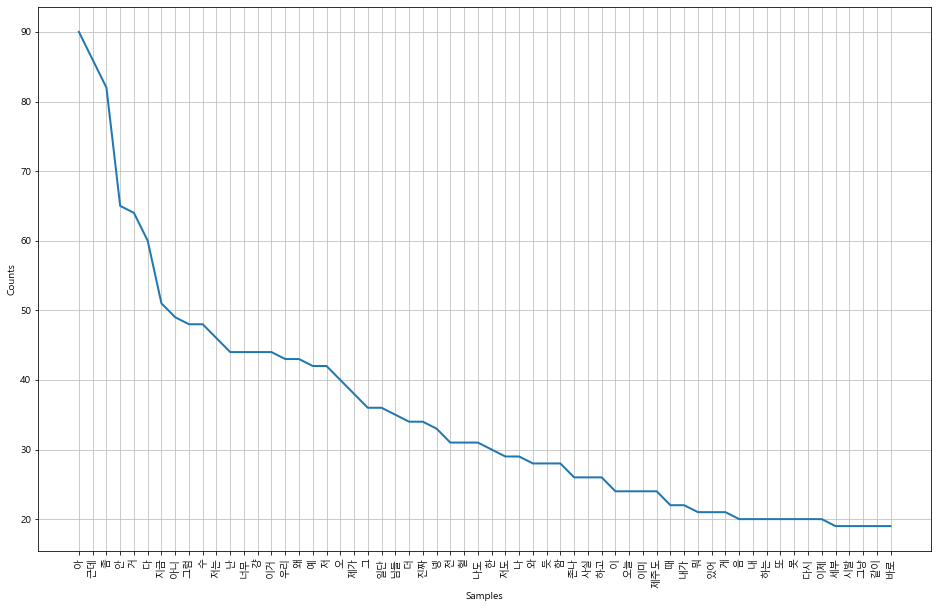

In [33]:
all_analysis()

## 사용자 별 빈도 분석

In [34]:
# 사용자 분석
users = set(cleaned_data["User"])
users

{'김완섭', '다은이♥♥♥', '박순혁', '쑴님', '엄수진 :-)'}

In [35]:
# 사용자 별로 데이터 groupby
from pprint import pprint
authors = cleaned_data.groupby("User")
pprint(authors.groups)
print(type(authors.groups))

{'김완섭': Int64Index([   7,    9,   10,   14,   15,   81,  111,  112,  197,  198,
            ...
            4919, 4936, 4937, 4938, 4943, 4949, 4981, 4984, 4990, 5014],
           dtype='int64', length=286),
 '다은이♥♥♥': Int64Index([   1,    4,   16,   17,   20,   25,   26,   27,   32,   35,
            ...
            5048, 5050, 5051, 5053, 5056, 5061, 5063, 5068, 5070, 5071],
           dtype='int64', length=1405),
 '박순혁': Int64Index([  38,   49,   50,   62,   63,   66,   67,   68,   73,   74,
            ...
            4901, 4952, 4953, 4954, 4960, 5021, 5042, 5043, 5045, 5067],
           dtype='int64', length=880),
 '쑴님': Int64Index([   5,    6,    8,   11,   12,   13,   18,   19,   21,   22,
            ...
            5049, 5054, 5058, 5059, 5060, 5062, 5064, 5065, 5066, 5069],
           dtype='int64', length=1566),
 '엄수진 :-)': Int64Index([   0,    2,    3,   39,   40,   46,   47,   48,   55,   56,
            ...
            4985, 4986, 4993, 4997, 5006, 5020, 5024, 5052, 5055

In [36]:
# 사용자 별로 묶은 데이터를 사용가능한 데이터 타입으로 변경
author2doc = {}

for user, index in authors.groups.items():
    author2doc[user] = list(index)
    
author2doc

{'김완섭': [7,
  9,
  10,
  14,
  15,
  81,
  111,
  112,
  197,
  198,
  220,
  308,
  309,
  310,
  367,
  379,
  381,
  415,
  605,
  606,
  607,
  614,
  615,
  616,
  642,
  679,
  681,
  682,
  683,
  740,
  741,
  743,
  746,
  750,
  751,
  756,
  757,
  763,
  777,
  840,
  853,
  856,
  861,
  890,
  937,
  939,
  940,
  1035,
  1037,
  1038,
  1133,
  1137,
  1138,
  1139,
  1175,
  1176,
  1206,
  1209,
  1211,
  1215,
  1216,
  1217,
  1231,
  1232,
  1253,
  1254,
  1256,
  1294,
  1297,
  1303,
  1305,
  1306,
  1309,
  1310,
  1312,
  1334,
  1336,
  1342,
  1345,
  1346,
  1349,
  1350,
  1367,
  1370,
  1371,
  1376,
  1382,
  1392,
  1403,
  1406,
  1416,
  1418,
  1425,
  1426,
  1433,
  1435,
  1509,
  1879,
  1899,
  1901,
  1906,
  1908,
  2023,
  2024,
  2027,
  2341,
  2342,
  2348,
  2349,
  2350,
  2375,
  2379,
  2388,
  2390,
  2393,
  2394,
  2446,
  2447,
  2552,
  2554,
  2555,
  2556,
  2561,
  2564,
  2624,
  2666,
  2667,
  2668,
  2672,
  2673,
  2679,


In [37]:
def user_freq_analysis(username, data, author2doc):
    
    user_msg = [str(data["Message"][idx]) for idx in author2doc[username]]
    total_tokens = [token for doc in user_msg for token in doc.split()]
    text = nltk.Text(total_tokens, name='kakao')

    #pprint(text.vocab().most_common(10))
    path = "c:/Windows/Fonts/malgun.ttf"
    if platform.system() == 'Darwin':
        rc('font', family='AppleGothic')
    elif platform.system() == 'Windows':
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    else:
        print('Unknown system... sorry~~~~')

    plt.figure(figsize=(16, 10))
    text.plot(50)

    wc = text.vocab().most_common(100)

박순혁


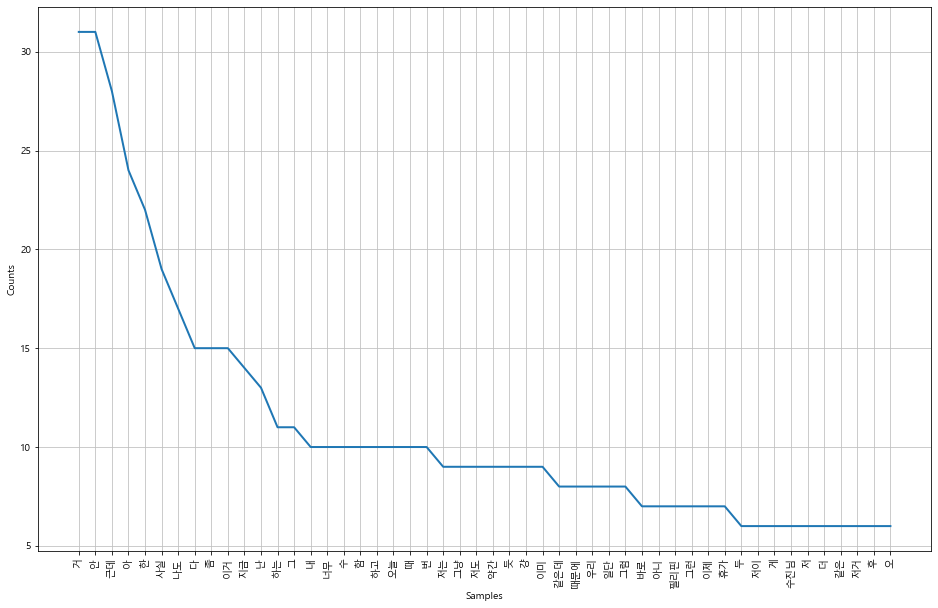

쑴님


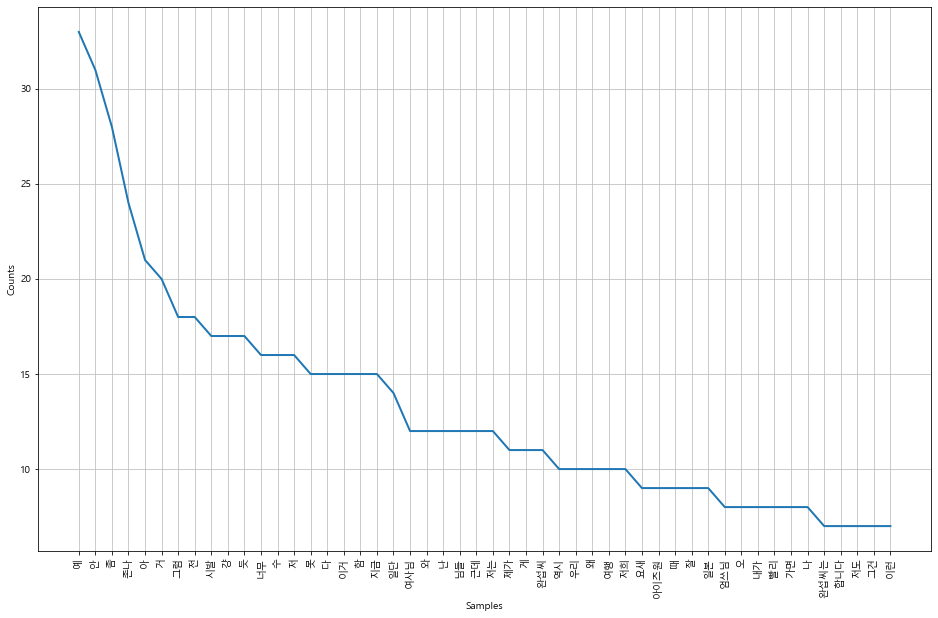

다은이♥♥♥


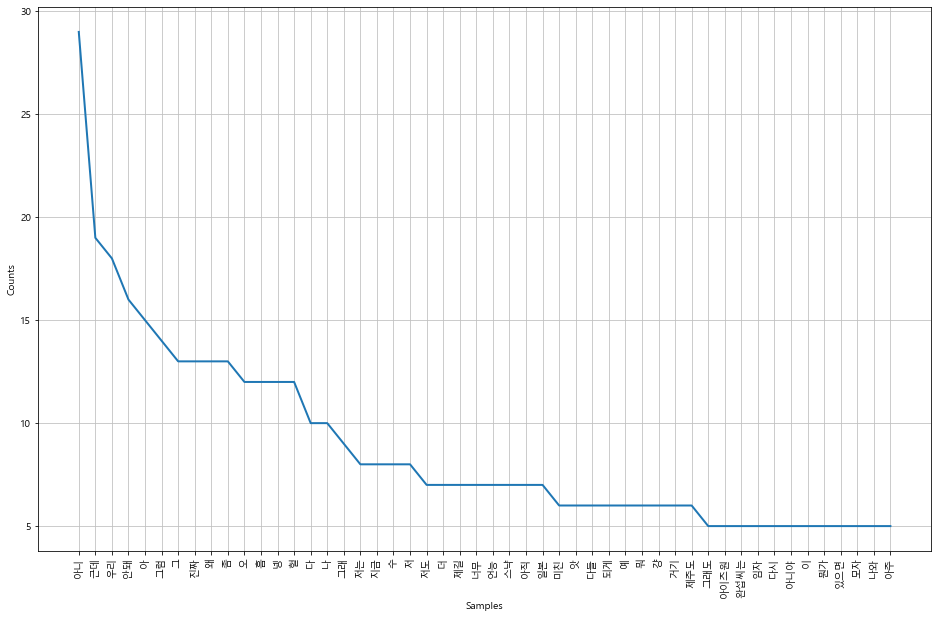

김완섭


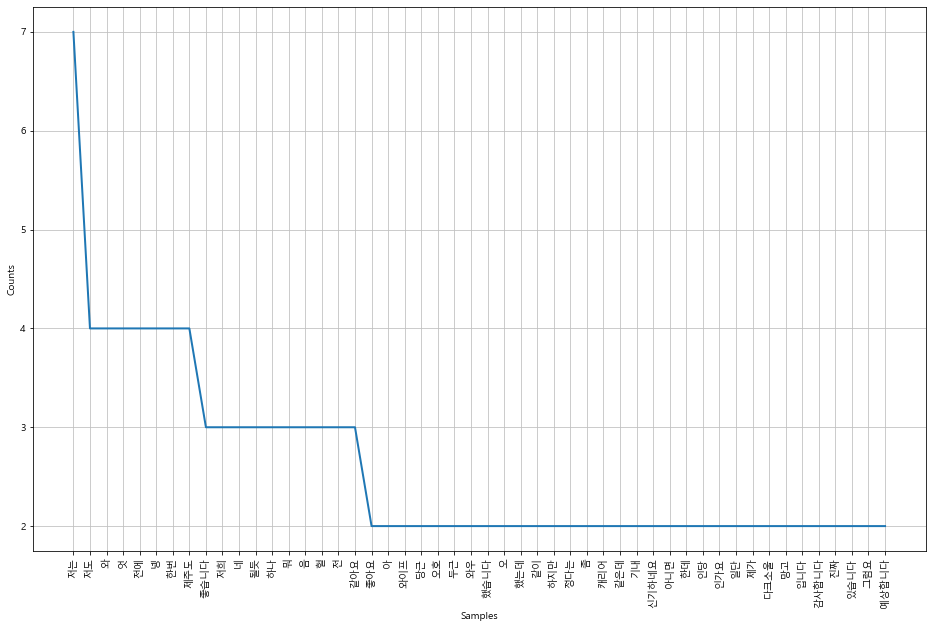

엄수진 :-)


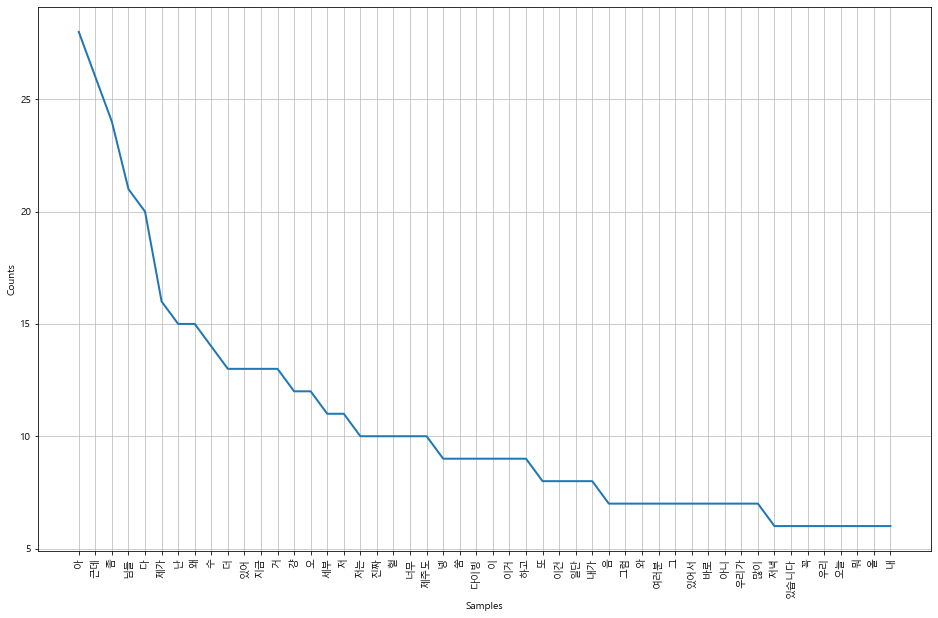

In [38]:
for user in users:
    if user != "(알 수 없음)" and user !="김영일] [오후 5:18":
        print(user)
        user_freq_analysis(user, cleaned_data, author2doc)

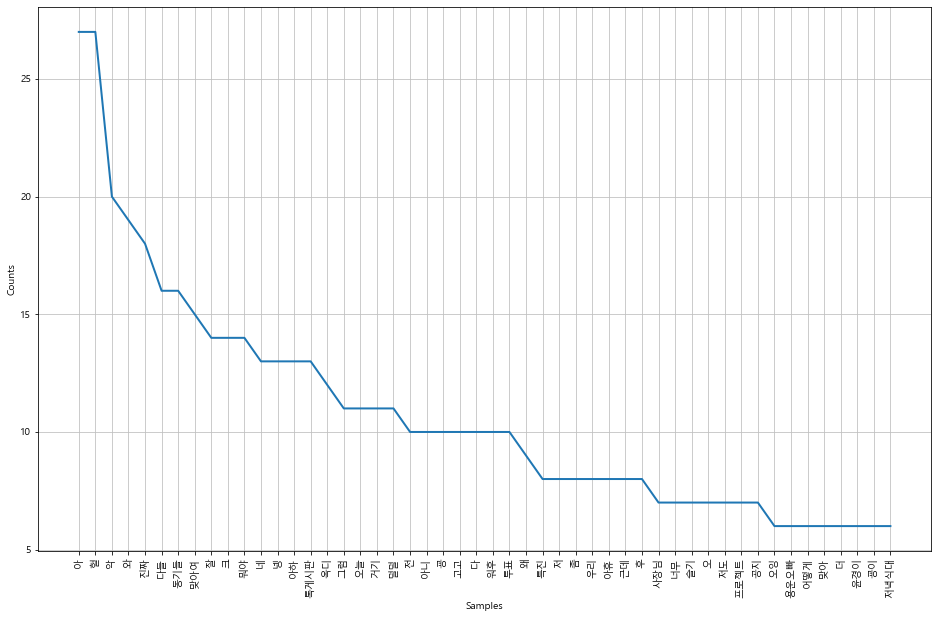

In [21]:
user_freq_analysis('김윤경', cleaned_data, author2doc)